In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax

from nnp_functions.pf_vehicle import PFVehicle
from nnp_functions.particle_filter import ParticleFilter
from nnp_functions.neural_networks import FeedForwardNetwork

In [2]:
TAU = 0.4 / (256)
X_BAR = jnp.log(0.16)
KAPPA = 12 # revert in a month
SIGMA_SIGMA = 6.4
RHO = -0.05

## Skew Stoch Vol State Space Functions

In [3]:
def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = last_val + TAU * KAPPA * (X_BAR - last_val)
    std = jnp.sqrt(TAU) * SIGMA_SIGMA
    next_val = noise * std + means
    return next_val

def f_sample_fn(subkey, particles, Y_array, idt):
    return f_from_noise(particles, jax.random.normal(subkey, len(particles)))
    



def skew_g_from_total_noise(prev_particle, particle, noise):
    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    return skew_total_mean + noise * jnp.sqrt(skew_total_var)

In [4]:
def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)  # Mean reversion
    f_std = jnp.sqrt(TAU) * SIGMA_SIGMA  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 

def skew_observation_weight_single(particle, prev_particle, Y_array, idt):

    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Skew-normal distribution parameters for Y[t]
    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO  * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    # Return log-likelihood: log P(Y[idt] | X_t, X_{t-1})
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), skew_total_mean, jnp.sqrt(skew_total_var))



# Experiments

Show:
- Better ESS with NN method. 
- No improvment in forecasting. 

In [5]:
TRAIN_KEY = jax.random.key(112)
DATA_KEY = jax.random.key(72)
EVAL_KEY = jax.random.key(80)
INIT_PARTICLE_KEY = jax.random.key(16)

In [6]:
skew_vol_vehicle = PFVehicle(f_from_noise, skew_g_from_total_noise, f_likelihood_single, skew_observation_weight_single)

skew_bootstrap_pf = ParticleFilter(f_sample_fn, skew_observation_weight_single)


  0%|          | 0/1000 [00:00<?, ?it/s]

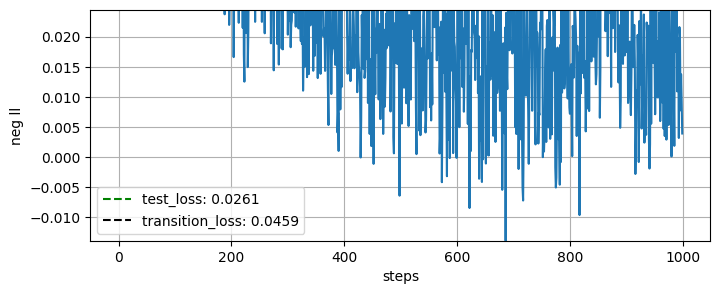

In [7]:
def transition_model(input):
    last_x, y = input
    mean = last_x + TAU * KAPPA * (X_BAR - last_x)
    scale = jnp.sqrt(TAU) * SIGMA_SIGMA
    return mean, scale

initial_model = FeedForwardNetwork(1, 64, jax.random.key(72))
skew_vol_vehicle.train_model(
    TRAIN_KEY, 
    initial_model,
    5000, 
    steps = 1000, 
    learning_rate=0.01,
    X_bar = X_BAR,
    transition_model=transition_model
)

# Experiment 1

In [8]:
PARTICLE_VALS = [5, 50, 100, 200, 400, 800, 1000]
SIMULATE_AT = [0.9]
N_RUNS = 5
N_TIMESTEPS = 1000

In [9]:
All_X, All_Y = skew_vol_vehicle.generate_data(
    DATA_KEY,
    N_RUNS,
    N_TIMESTEPS,
    starting_point = X_BAR
)

In [10]:
def stack_dicts(dict_list):
    return {
        key: jnp.stack([d[key] for d in dict_list], axis=0)
        for key in dict_list[0]
    }

In [11]:
total_n_merged_diag = {}
total_n_forecast_metrics = {}
total_b_merged_diag = {}
total_b_forecast_metrics = {}

eval_key = EVAL_KEY

print("Starting particle filter experiments across different particle counts...")
for particle_N in PARTICLE_VALS:
    print(f"\n{'='*60}")
    print(f"Running experiments for particle count: {particle_N}")

    initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (particle_N,)) * 0.1 + X_BAR
    initial_log_weights = jnp.zeros(particle_N) - jnp.log(particle_N)

    print("  - Initializing neural network particle filter...")
    nn_particle_filter = skew_vol_vehicle.build_NN_particle_filter(N_PARTICLES = particle_N)
    print("  - Initializing bootstrap particle filter...")
    stoch_bootstrap_pf = ParticleFilter(f_sample_fn, skew_observation_weight_single, N_PARTICLES = particle_N)

    nn_merged_diag_list = []
    bootstrap_merged_diag_list = []

    nn_total_forecast_metrics = []
    bootstrap_total_forecast_metrics = []
    
    for run_idx in range(N_RUNS):

        key, eval_key = jax.random.split(eval_key)

        print(f"    > Run {run_idx+1}/{N_RUNS} for particle_N={particle_N} (NN PF)...")
        Y_array, X_array = All_Y[run_idx], All_X[run_idx]

        nn_merge, _, nn_forecast_metrics = skew_vol_vehicle.run_from_particle_filter(
            key, nn_particle_filter, Y_array, X_array, initial_particles,
            simulate_at = SIMULATE_AT,
            tau = TAU
        )
        print(f"      - Neural network PF diagnostics collected.")

        nn_merged_diag_list.append(nn_merge)
        nn_total_forecast_metrics.append(nn_forecast_metrics)

        print(f"    > Run {run_idx+1}/{N_RUNS} for particle_N={particle_N} (Bootstrap PF)...")
        bootstrap_merge, _, bootstrap_forecast_metrics = skew_vol_vehicle.run_from_particle_filter(
            key, stoch_bootstrap_pf, Y_array, X_array, initial_particles,
            simulate_at = SIMULATE_AT,
            tau = TAU
        )
        print(f"      - Bootstrap PF diagnostics collected.")

        bootstrap_merged_diag_list.append(bootstrap_merge)
        bootstrap_total_forecast_metrics.append(bootstrap_forecast_metrics)

    print(f"  - Aggregating diagnostics for particle_N={particle_N}...")
    total_n_merged_diag[particle_N] = stack_dicts(nn_merged_diag_list)
    total_b_merged_diag[particle_N] = stack_dicts(bootstrap_merged_diag_list)
    total_n_forecast_metrics[particle_N] = (nn_total_forecast_metrics)
    total_b_forecast_metrics[particle_N] = (bootstrap_total_forecast_metrics)
    print(f"  - Completed aggregation for particle_N={particle_N}.")

print("\nAll particle filter experiments completed successfully.")


Starting particle filter experiments across different particle counts...

Running experiments for particle count: 5
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/5 for particle_N=5 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/5 for particle_N=5 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/5 for particle_N=5 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/5 for particle_N=5 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/5 for particle_N=5 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/5 for particle_N=5 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/5 for particle_N=5 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/5 for particle_N=5 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/5 for particle_N=5 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/5 for particle_N=5 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=5...
  - Completed aggregation for particle_N=5.

Running experiments for particle count: 50
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/5 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/5 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/5 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/5 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/5 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/5 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/5 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/5 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/5 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/5 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=50...
  - Completed aggregation for particle_N=50.

Running experiments for particle count: 100
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/5 for particle_N=100 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/5 for particle_N=100 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/5 for particle_N=100 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/5 for particle_N=100 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/5 for particle_N=100 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/5 for particle_N=100 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/5 for particle_N=100 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/5 for particle_N=100 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/5 for particle_N=100 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/5 for particle_N=100 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=100...
  - Completed aggregation for particle_N=100.

Running experiments for particle count: 200
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/5 for particle_N=200 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/5 for particle_N=200 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/5 for particle_N=200 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/5 for particle_N=200 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/5 for particle_N=200 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/5 for particle_N=200 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/5 for particle_N=200 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/5 for particle_N=200 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/5 for particle_N=200 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/5 for particle_N=200 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=200...
  - Completed aggregation for particle_N=200.

Running experiments for particle count: 400
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/5 for particle_N=400 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/5 for particle_N=400 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/5 for particle_N=400 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/5 for particle_N=400 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/5 for particle_N=400 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/5 for particle_N=400 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/5 for particle_N=400 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/5 for particle_N=400 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/5 for particle_N=400 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/5 for particle_N=400 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=400...
  - Completed aggregation for particle_N=400.

Running experiments for particle count: 800
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/5 for particle_N=800 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/5 for particle_N=800 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/5 for particle_N=800 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/5 for particle_N=800 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/5 for particle_N=800 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/5 for particle_N=800 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/5 for particle_N=800 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/5 for particle_N=800 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/5 for particle_N=800 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/5 for particle_N=800 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=800...
  - Completed aggregation for particle_N=800.

Running experiments for particle count: 1000
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/5 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/5 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/5 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/5 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/5 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/5 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/5 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/5 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/5 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/5 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=1000...
  - Completed aggregation for particle_N=1000.

All particle filter experiments completed successfully.


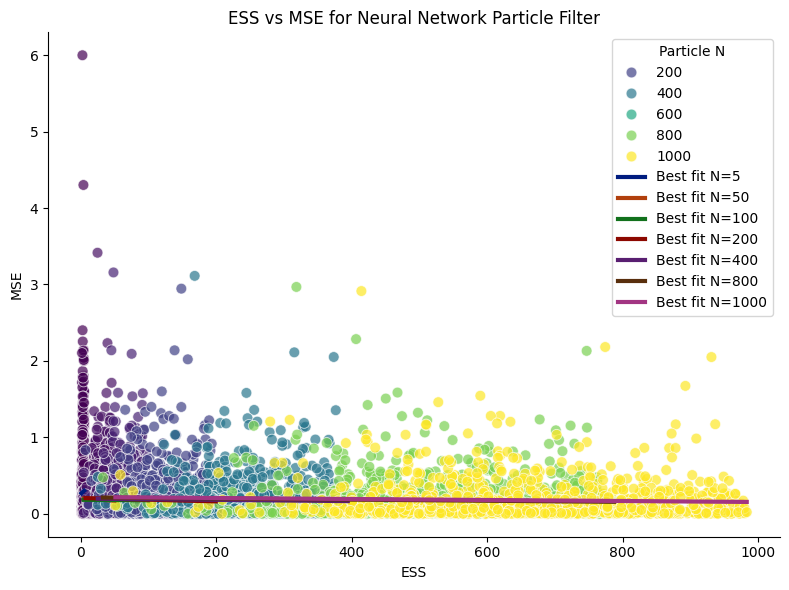

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare data for plotting: scatter every (ess, mse) point
plot_data = []
for particle_N, diag in total_n_merged_diag.items():
    ess = np.array(diag['ess'])
    mse = np.array(diag['mean_squared_error'])
    # Flatten both arrays to 1D
    ess_flat = ess.flatten()
    mse_flat = mse.flatten()
    for e, m in zip(ess_flat, mse_flat):
        plot_data.append({'particle_N': particle_N, 'ess': e, 'mse': m})

df = pd.DataFrame(plot_data)

# Reduce density by subsampling (e.g., every 5th point)
subsample_rate = 5
df_sub = df.iloc[::subsample_rate, :]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sub, x='ess', y='mse', hue='particle_N', palette='viridis', s=60, alpha=0.7)

# Plot best fit lines for each particle_N, using dark colors for visibility
unique_particle_N = sorted(df_sub['particle_N'].unique())
# Use a dark palette for the lines
dark_colors = sns.color_palette('dark', n_colors=len(unique_particle_N))
for idx, particle_N in enumerate(unique_particle_N):
    sub = df_sub[df_sub['particle_N'] == particle_N]
    if len(sub) > 1:
        # Fit line: polyfit degree 1
        coeffs = np.polyfit(sub['ess'], sub['mse'], deg=1)
        ess_range = np.linspace(sub['ess'].min(), sub['ess'].max(), 100)
        mse_fit = np.polyval(coeffs, ess_range)
        plt.plot(
            ess_range, mse_fit,
            color=dark_colors[idx],
            label=f'Best fit N={particle_N}',
            linewidth=3,  # Thicker line for visibility
            alpha=1.0,    # Fully opaque for darkness
            zorder=10
        )

plt.title('ESS vs MSE for Neural Network Particle Filter')
plt.xlabel('ESS')
plt.ylabel('MSE')
plt.legend(title='Particle N')
sns.despine()
plt.tight_layout()
plt.show()


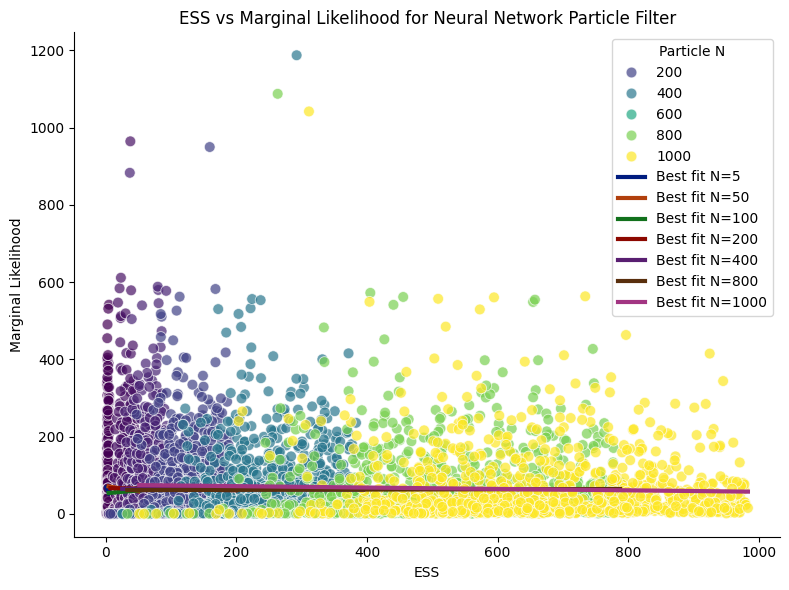

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare data for plotting: scatter every (ess, marginal_likelihood) point
plot_data = []
for particle_N, diag in total_n_merged_diag.items():
    ess = np.array(diag['ess'])
    marginal_likelihood = np.array(diag['marginal_likelihood'])
    # Flatten both arrays to 1D
    ess_flat = ess.flatten()
    ml_flat = marginal_likelihood.flatten()
    for e, m in zip(ess_flat, ml_flat):
        plot_data.append({'particle_N': particle_N, 'ess': e, 'marginal_likelihood': m})

df = pd.DataFrame(plot_data)

# Reduce density by subsampling (e.g., every 5th point)
subsample_rate = 5
df_sub = df.iloc[::subsample_rate, :]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sub, x='ess', y='marginal_likelihood', hue='particle_N', palette='viridis', s=60, alpha=0.7)

# Plot best fit lines for each particle_N, using dark colors for visibility
unique_particle_N = sorted(df_sub['particle_N'].unique())
# Use a dark palette for the lines
dark_colors = sns.color_palette('dark', n_colors=len(unique_particle_N))
for idx, particle_N in enumerate(unique_particle_N):
    sub = df_sub[df_sub['particle_N'] == particle_N]
    if len(sub) > 1:
        # Fit line: polyfit degree 1
        coeffs = np.polyfit(sub['ess'], sub['marginal_likelihood'], deg=1)
        ess_range = np.linspace(sub['ess'].min(), sub['ess'].max(), 100)
        ml_fit = np.polyval(coeffs, ess_range)
        plt.plot(
            ess_range, ml_fit,
            color=dark_colors[idx],
            label=f'Best fit N={particle_N}',
            linewidth=3,  # Thicker line for visibility
            alpha=1.0,    # Fully opaque for darkness
            zorder=10
        )

plt.title('ESS vs Marginal Likelihood for Neural Network Particle Filter')
plt.xlabel('ESS')
plt.ylabel('Marginal Likelihood')
plt.legend(title='Particle N')
sns.despine()
plt.tight_layout()
plt.show()
